# 2D-PCA 实验
本实验基于 Olivetti 人脸数据集实现二维主成分分析 (2D-PCA)，直接在图像矩阵上求解投影方向，并展示协方差矩阵、特征向量以及重构效果。

In [1]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_olivetti_faces


In [2]:
# 配置 matplotlib 支持中文显示
plt.rcParams["font.sans-serif"] = [
    "Sarasa Gothic SC",
    "Noto Sans CJK SC",
    "Microsoft YaHei",
    "WenQuanYi Micro Hei",
]
plt.rcParams["axes.unicode_minus"] = False


In [3]:
# 加载数据集并确保缓存到 data/ 目录
data_dir = Path("..") / "data"
data_dir.mkdir(parents=True, exist_ok=True)
faces = fetch_olivetti_faces(data_home=data_dir, shuffle=True, random_state=0)
images = faces.images
n_samples, h, w = images.shape
print(f"样本数: {n_samples}, 图像尺寸: {h}x{w}")


样本数: 400, 图像尺寸: 64x64


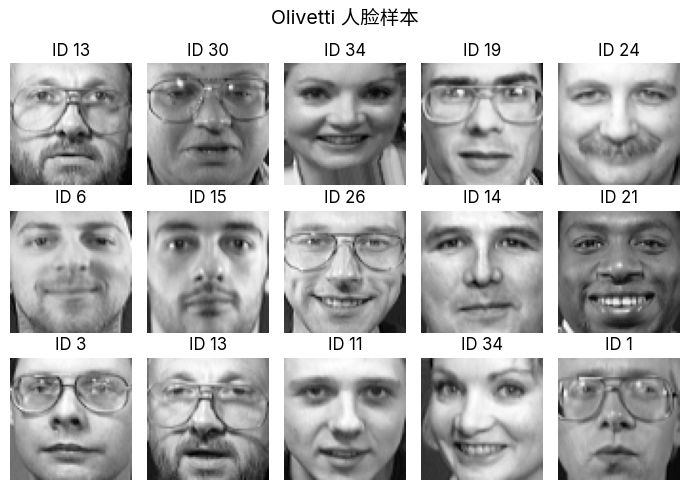

In [4]:
# 展示部分样本
fig, axes = plt.subplots(3, 5, figsize=(7, 5))
for ax, img, label in zip(axes.ravel(), images[:15], faces.target[:15]):
    ax.imshow(img, cmap="gray")
    ax.set_title(f"ID {label}")
    ax.axis("off")
plt.suptitle("Olivetti 人脸样本", fontsize=14)
plt.tight_layout()
plt.show()


## 2D-PCA 算法步骤
1. 计算所有人脸图像的均值矩阵；
2. 构造图像散度矩阵 $G = \frac{1}{N}\sum (A_i - \bar{A})^T (A_i - \bar{A})$；
3. 对 $G$ 进行特征分解，获取投影矩阵 $W$；
4. 通过 $Y = (A - \bar{A}) W$ 对每张图像进行降维；
5. 可使用前 $k$ 个特征向量进行重构与分类实验。

In [5]:
# 构造图像均值与散度矩阵
mean_image = images.mean(axis=0)
scatter_matrix = np.zeros((w, w), dtype=np.float64)
row_scatter = np.zeros((h, h), dtype=np.float64)
for img in images:
    diff = img - mean_image
    scatter_matrix += diff.T @ diff
    row_scatter += diff @ diff.T
scatter_matrix /= n_samples
row_scatter /= n_samples
print(f"散度矩阵形状: {scatter_matrix.shape}")
print("散度矩阵前 5x5 子块:")
print(np.round(scatter_matrix[:5, :5], 5))
print(f"行方向散度矩阵形状: {row_scatter.shape}")
print("行方向散度矩阵前 5x5 子块:")
print(np.round(row_scatter[:5, :5], 5))


散度矩阵形状: (64, 64)
散度矩阵前 5x5 子块:
[[2.02882 1.77341 1.46338 1.22394 1.03918]
 [1.77341 1.98221 1.72714 1.41497 1.20028]
 [1.46338 1.72714 1.9152  1.65983 1.36648]
 [1.22394 1.41497 1.65983 1.79471 1.54971]
 [1.03918 1.20028 1.36648 1.54971 1.65145]]
行方向散度矩阵形状: (64, 64)
行方向散度矩阵前 5x5 子块:
[[1.36052 1.30979 1.24464 1.17529 1.09744]
 [1.30979 1.28947 1.24148 1.18126 1.1092 ]
 [1.24464 1.24148 1.22358 1.18408 1.12466]
 [1.17529 1.18126 1.18408 1.18188 1.15228]
 [1.09744 1.1092  1.12466 1.15228 1.17752]]


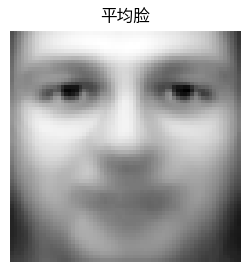

In [6]:
plt.figure(figsize=(3, 3))
plt.imshow(mean_image, cmap="gray")
plt.title("平均脸")
plt.axis("off")
plt.show()


In [7]:
# 对散度矩阵进行特征分解
eigvals, eigvecs = np.linalg.eigh(scatter_matrix)
sort_idx = np.argsort(eigvals)[::-1]
eigvals = eigvals[sort_idx]
eigvecs = eigvecs[:, sort_idx]
print("前 10 个特征值:", np.round(eigvals[:10], 5))


前 10 个特征值: [30.52999 12.31335  9.42933  6.50037  2.98431  2.63956  1.8606   1.63482
  1.37579  1.14689]


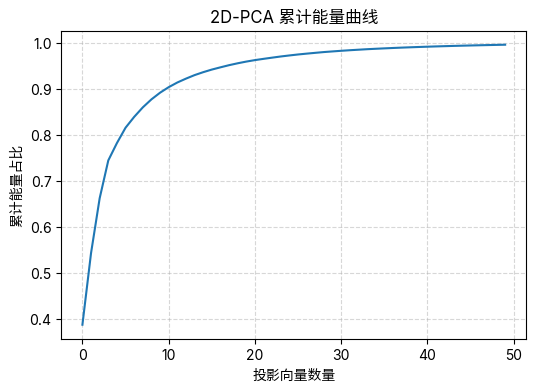

In [8]:
# 计算累计能量贡献率
energy_ratio = eigvals / eigvals.sum()
cumulative_energy = np.cumsum(energy_ratio)
plt.figure(figsize=(6, 4))
plt.plot(cumulative_energy[:50])
plt.xlabel("投影向量数量")
plt.ylabel("累计能量占比")
plt.title("2D-PCA 累计能量曲线")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()


## 2D-PCA 子重构公式说明

对于图像样本 $A$（尺寸 $h \times w$），列方向的协方差矩阵：
$$
G = \frac{1}{N} \sum_{i=1}^N (A_i - \bar{A})^T (A_i - \bar{A})
$$

其特征向量 $X_k$（$w$ 维列向量）构成最优投影方向集合 $\{X_1, ..., X_d\}$。

- 单个投影向量的特征表示：
    $$
    Y_k = A X_k \quad (\text{得到 $h$ 维列向量})
    $$

- 单个“子重构”子图像：
    $$
    \tilde{A}_k = Y_k X_k^T = (A X_k) X_k^T \quad (\text{仍为 $h \times w$ 尺寸})
    $$

- 原图像可近似为前 $d$ 个子重构之和：
    $$
    A \approx \sum_{k=1}^d \tilde{A}_k
    $$
    若 $d = w$（全部特征向量），则 $\sum_{k=1}^w \tilde{A}_k = A$。

下方代码演示：

1. 显示若干单个投影向量对应的子重构图像。
2. 累积前 $d$ 个子重构并与原图像对比差异。



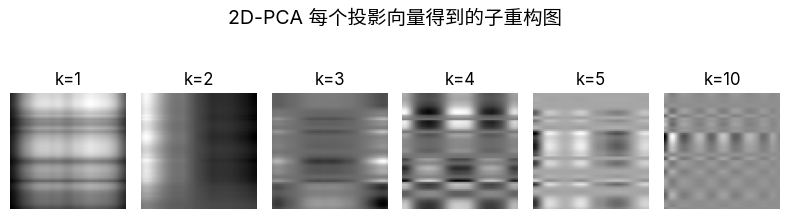

In [19]:
# 2D-PCA 子重构图像
sample_idx = 0  # 选择要展示的人脸索引
A = images[sample_idx]
# 需要展示的投影向量索引（按特征值降序选取）
k_list = [1, 2, 3, 4, 5, 10]
fig, axes = plt.subplots(1, len(k_list), figsize=(8, 2.6))
for ax, k in zip(axes, k_list):
    xk = eigvecs[:, k - 1]  # 第 k 个投影向量 X_k
    yk = A @ xk  # Y_k = A X_k (h 维)
    sub_recon = np.outer(yk, xk)
    # 归一化到 [0,1]
    norm = (sub_recon - sub_recon.min()) / (sub_recon.max() - sub_recon.min() + 1e-8)
    ax.imshow(norm, cmap="gray", vmin=0, vmax=1)
    ax.set_title(f"k={k}")
    ax.axis("off")
plt.suptitle("2D-PCA 每个投影向量得到的子重构图", fontsize=14)
plt.tight_layout()
plt.show()


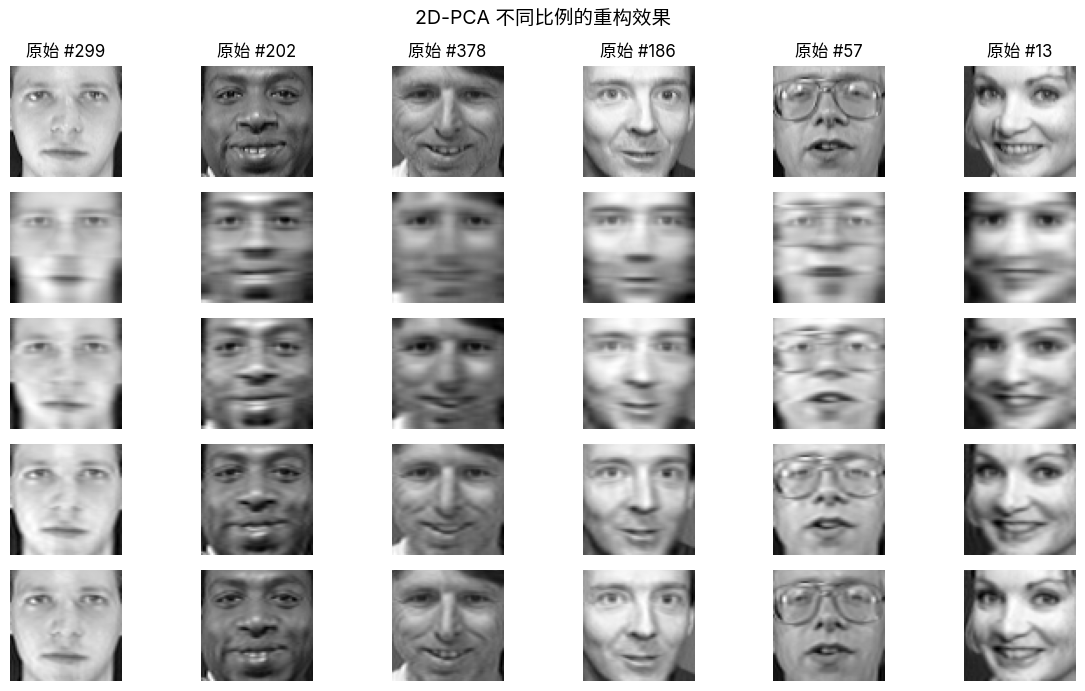

In [10]:
# 选择前 k 个投影向量进行重构演示
k_values = [5, 10, 20, 30]
fig, axes = plt.subplots(len(k_values) + 1, 6, figsize=(12, 7))
selected_indices = np.random.default_rng(1).choice(n_samples, size=6, replace=False)
for col, idx in enumerate(selected_indices):
    axes[0, col].imshow(images[idx], cmap="gray")
    axes[0, col].set_title(f"原始 #{idx}")
    axes[0, col].axis("off")
for row, k in enumerate(k_values, start=1):
    W = eigvecs[:, :k]
    for col, idx in enumerate(selected_indices):
        centered = images[idx] - mean_image
        reconstruction = centered @ W @ W.T + mean_image
        axes[row, col].imshow(reconstruction, cmap="gray")
        if col == 0:
            axes[row, col].set_ylabel(f"k={k}", rotation=0, labelpad=30)
        axes[row, col].axis("off")
fig.suptitle("2D-PCA 不同比例的重构效果", fontsize=14)
plt.tight_layout()
plt.show()


In [11]:
# 使用 2D-PCA 特征进行简单的 1-NN 分类实验
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

k_feature = 20
W_feature = eigvecs[:, :k_feature]
projected_features = [(img - mean_image) @ W_feature for img in images]
X_features = np.array([feat.flatten() for feat in projected_features])
X_train, X_test, y_train, y_test, img_train, img_test = train_test_split(
    X_features,
    faces.target,
    images,
    test_size=0.25,
    random_state=42,
    stratify=faces.target,
)
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)
accuracy = knn.score(X_test, y_test)
print(f"2D-PCA 前 {k_feature} 个向量的 1-NN 准确率: {accuracy:.3f}")


2D-PCA 前 20 个向量的 1-NN 准确率: 0.930


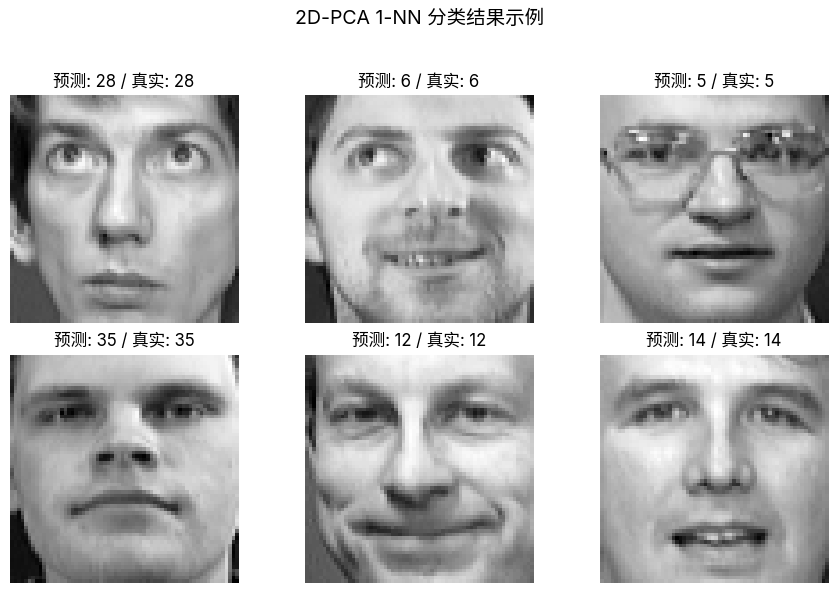

In [12]:
display_rng = np.random.default_rng(2)
sample_count = 6
sample_indices = display_rng.choice(len(X_test), size=sample_count, replace=False)
sample_predictions = knn.predict(X_test[sample_indices])

fig, axes = plt.subplots(2, 3, figsize=(9, 6))
for ax, idx, pred in zip(axes.ravel(), sample_indices, sample_predictions):
    ax.imshow(img_test[idx], cmap="gray")
    ax.set_title(f"预测: {pred} / 真实: {y_test[idx]}")
    ax.axis("off")
fig.suptitle("2D-PCA 1-NN 分类结果示例", fontsize=14)
plt.tight_layout(rect=(0, 0, 1, 0.95))
plt.show()


> 2D-PCA 避免了高维协方差矩阵求解的开销，直接在矩阵空间寻找投影方向，适合中等尺寸的人脸图像。